In [79]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras import preprocessing
import os
import re
import shutil
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
import string
import numpy as np

In [6]:
url = "https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz"


dataset = tf.keras.utils.get_file("imdb", url,
                                    untar=True, cache_dir='.',
                                    cache_subdir='')


84131840/84125825 [==============================] - 3s 0us/step


In [7]:
dir = os.path.join(os.path.dirname(dataset),"aclImdb/")

In [9]:
os.listdir(dir)

['train', 'README', 'test', 'imdb.vocab', 'imdbEr.txt']

In [10]:
train_dir = os.path.join(os.path.dirname(dir),"train")

In [11]:
os.listdir(train_dir)

['urls_neg.txt',
 'urls_unsup.txt',
 'labeledBow.feat',
 'urls_pos.txt',
 'neg',
 'pos',
 'unsup',
 'unsupBow.feat']

In [13]:
with open(train_dir+"/pos/0_9.txt") as f:
  print(f.read())

Bromwell High is a cartoon comedy. It ran at the same time as some other programs about school life, such as "Teachers". My 35 years in the teaching profession lead me to believe that Bromwell High's satire is much closer to reality than is "Teachers". The scramble to survive financially, the insightful students who can see right through their pathetic teachers' pomp, the pettiness of the whole situation, all remind me of the schools I knew and their students. When I saw the episode in which a student repeatedly tried to burn down the school, I immediately recalled ......... at .......... High. A classic line: INSPECTOR: I'm here to sack one of your teachers. STUDENT: Welcome to Bromwell High. I expect that many adults of my age think that Bromwell High is far fetched. What a pity that it isn't!


In [14]:
rmdir = os.path.join(train_dir,"unsup")
shutil.rmtree(rmdir)

In [16]:
train_ds = tf.keras.preprocessing.text_dataset_from_directory(
    train_dir,
    batch_size = 32,
    validation_split = 0.2,
    seed = 42,
    subset = "training",
)


Found 25000 files belonging to 2 classes.
Using 20000 files for training.


In [23]:
for review, label in train_ds.take(1):
  for i in range(3):
    print("Review - ",review.numpy()[i])
    print("Label - ",train_ds.class_names[label.numpy()[i]])

Review -  b"I went to see Fever Pitch with my Mom, and I can say that we both loved it. It wasn't the typical romantic comedy where someone is pining for the other, and blah blah blah... You weren't waiting for the climatic first kiss or for them to finally get together. It was more real, because you saw them through the relationship, rather than the whole movie be about them getting together. People could actually relate to the film, because it didn't seem like extraordinary circumstances, or impossible situations. It was really funny, and I think it was Jimmy Fallon's best performance. All in all... I would definitely recommend it!"
Label -  pos
Review -  b"from the view of a NASCAR Maniac like I am, the movie is interesting. You can see many race cars from 1983. Even tough, the racing scenes are not that much realistic. But I have to admit, that I haven't seen any race before 1995, because before that time, they didn't show any NASCAR races in Germany)<br /><br />from the view of a 

In [24]:
train_ds.class_names

['neg', 'pos']

In [25]:
val_ds = tf.keras.preprocessing.text_dataset_from_directory(
    train_dir,
    batch_size = 32,
    validation_split = 0.2,
    seed = 42,
    subset = "validation",
)

Found 25000 files belonging to 2 classes.
Using 5000 files for validation.


In [106]:
def custom_normalization(input_data):
  ip = tf.strings.lower(input_data)
  strip_html = tf.strings.regex_replace(ip,"<br />"," ")
  return tf.strings.regex_replace(
      strip_html,
      '[%s]' %print(re.escape(string.punctuation)),
      ""
  )

In [107]:
max_features = 10000
sequence_length = 250

vectorize_layer = TextVectorization(
    standardize=custom_normalization,
    max_tokens=max_features,
    output_mode='int',
    output_sequence_length=sequence_length)

In [108]:
vectorize_layer

In [109]:
train_text = train_ds.map(lambda x, y : x)
vectorize_layer.adapt(train_text)

!"\#\$%\&'\(\)\*\+,\-\./:;<=>\?@\[\\\]\^_`\{\|\}\~


In [110]:
def vectorize_text(text, label):
  text = tf.expand_dims(text, -1)
  return vectorize_layer(text), label

In [111]:
text_batch, label_batch = next(iter(train_ds))
first_review, first_label = text_batch[0], label_batch[0]
print("Review", first_review)
print("Label", train_ds.class_names[first_label])
print("Vectorized review", vectorize_text(first_review, first_label))

Review tf.Tensor(b'I love horror movies that brings out a real amount of mystery like say "silent hill" ( which i found to be quite good, but still, was missing something ) and movies that keeps you guessing, this i thought was one of those movies. At first the movie starts out with some really good suspense and builds up a good starting point for a good horror scene, but after that it just rolls down the hill and from there it only goes faster and faster down. I mentioned silent hill at first for a reason because i can see a lot of "stolen" themes from that movie in here.. All in all i would say, watch silent hill instead of this one, its better, its more scary, it has a lot more suspense and also the ending is a lot better.. And best of all, you wont feel ripped off as i did with this one.. This just seems to be one of those "i like that movie so I\'m gonna re-make it in my own really bad version" kinda movie.. Oh and one more thing... Lordi.. in a horror movie... thats like trying t

In [112]:
len(vectorize_layer.get_vocabulary())

10000

In [43]:
train = train_ds.map(vectorize_text)
val = val_ds.map(vectorize_text)

In [44]:
AUTOTUNE = tf.data.AUTOTUNE
training = train.cache().prefetch(buffer_size=AUTOTUNE)
validation = val.cache().prefetch(buffer_size=AUTOTUNE)

In [105]:
model = tf.keras.Sequential([
                             layers.Embedding(max_features + 1, 16),
                             layers.Dropout(0.2),
                             layers.GlobalAveragePooling1D(),
                             layers.Dense(1,activation="sigmoid")
])

In [90]:
model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, None, 16)          160016    
_________________________________________________________________
dropout_6 (Dropout)          (None, None, 16)          0         
_________________________________________________________________
global_average_pooling1d_4 ( (None, 16)                0         
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 17        
Total params: 160,033
Trainable params: 160,033
Non-trainable params: 0
_________________________________________________________________


In [91]:
model.compile(loss="binary_crossentropy",
              optimizer='adam',
              metrics=["accuracy"])

In [92]:
epochs = 10
history = model.fit(
    training,
    validation_data=validation,
    epochs=epochs)

Epoch 1/10
625/625 [==============================] - 5s 7ms/step - loss: 0.6588 - accuracy: 0.6967 - val_loss: 0.6039 - val_accuracy: 0.7782
Epoch 2/10
625/625 [==============================] - 4s 6ms/step - loss: 0.5333 - accuracy: 0.8073 - val_loss: 0.4835 - val_accuracy: 0.8262
Epoch 3/10
625/625 [==============================] - 4s 6ms/step - loss: 0.4280 - accuracy: 0.8508 - val_loss: 0.4076 - val_accuracy: 0.8508
Epoch 4/10
625/625 [==============================] - 4s 6ms/step - loss: 0.3630 - accuracy: 0.8697 - val_loss: 0.3642 - val_accuracy: 0.8634
Epoch 5/10
625/625 [==============================] - 4s 7ms/step - loss: 0.3221 - accuracy: 0.8810 - val_loss: 0.3375 - val_accuracy: 0.8678
Epoch 6/10
625/625 [==============================] - 4s 7ms/step - loss: 0.2921 - accuracy: 0.8942 - val_loss: 0.3199 - val_accuracy: 0.8728
Epoch 7/10
625/625 [==============================] - 4s 7ms/step - loss: 0.2685 - accuracy: 0.9014 - val_loss: 0.3078 - val_accuracy: 0.8742
Epoch 

In [93]:
test_dataset = tf.keras.preprocessing.text_dataset_from_directory(
    "aclImdb/test",
    batch_size = 32
)

Found 25000 files belonging to 2 classes.


In [95]:
test = test_dataset.map(vectorize_text)

In [96]:
test_ds = test.cache().prefetch(buffer_size=AUTOTUNE)

In [97]:
loss, accuracy = model.evaluate(test_ds)

print("Loss: ", loss)
print("Accuracy: ", accuracy)

782/782 [==============================] - 8s 11ms/step - loss: 0.3088 - accuracy: 0.8740
Loss:  0.3088075816631317
Accuracy:  0.8740400075912476


In [98]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

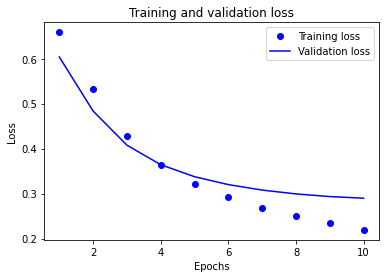

In [99]:
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

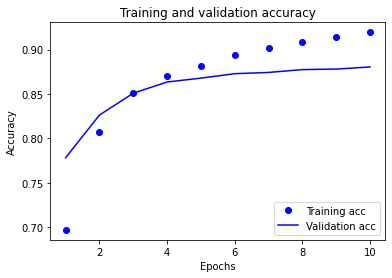

In [103]:
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.show()

In [100]:
export_model = tf.keras.Sequential([
  vectorize_layer,
  model
])

export_model.compile(
    loss=losses.BinaryCrossentropy(from_logits=False), optimizer="adam", metrics=['accuracy']
)

loss, accuracy = export_model.evaluate(test_dataset)
print(accuracy)

782/782 [==============================] - 9s 11ms/step - loss: 0.3088 - accuracy: 0.8740
0.8740400075912476


In [101]:
examples = [
            "Wow, this movie is very good!!",
            "Great movie",
            "worst movie"
]

In [102]:
export_model.predict(examples)

array([[0.5722709 ],
       [0.6344793 ],
       [0.29358393]], dtype=float32)